In [11]:
#We initialize registration by aligning the centers of the two volumes. To qualitatively evaluate the result we use a linked cursor approach, click on one image and the corresponding point is added to the other image.rt matplotlib.pyplot as plt
from myshow import myshow, myshow3d
import SimpleITK as sitk
import registration_gui as rgui
%matplotlib notebook
import gui
import numpy as np
import matplotlib.pyplot as plt

<h1 align="center">Basic Registration</h1>


**Summary:**

1. Creating an instance of the registration framework requires selection of the following components:
   * Optimizer.
   * Similarity metric.
   * Interpolator.
2. The registration framework only supports images with sitkFloat32 and sitkFloat64 pixel types (use the SimpleITK <a href="http://www.itk.org/SimpleITKDoxygen/html/namespaceitk_1_1simple.html#af8c9d7cc96a299a05890e9c3db911885">Cast()</a> function if your image's pixel type is something else).

3. Successful registration is highly dependent on initialization. In general you can:
   * Use auxiliary information or user interaction to obtain an initial transformation (avoid resampling).
   * Center the images using the <a href="https://itk.org/SimpleITKDoxygen/html/classitk_1_1simple_1_1CenteredTransformInitializerFilter.html">CenteredTransformInitializer</a>.
   * Coarsely sample the parameter space using the <a href="https://itk.org/Doxygen/html/classitk_1_1ExhaustiveOptimizerv4.html">Exhaustive Optimizer</a> to obtain one or more initial transformation estimates.
   * Manually initialize, via direct manipulation of transformation parameters and visualization or localization of corresponding points in the two images and then use the <a href="https://itk.org/SimpleITKDoxygen/html/classitk_1_1simple_1_1LandmarkBasedTransformInitializerFilter.html">LandmarkBasedTransformInitializer</a>.

## REGISTRATION
### Read Image

We first read the images, specifying the pixel type that is required for registration (Float32 or Float64) and look at them. In this notebook we use a CT and MR image from the same patient. These are part of the training data from the Retrospective Image Registration Evaluation (<a href="http://www.insight-journal.org/rire/">RIRE</a>) project.

<IPython.core.display.Javascript object>


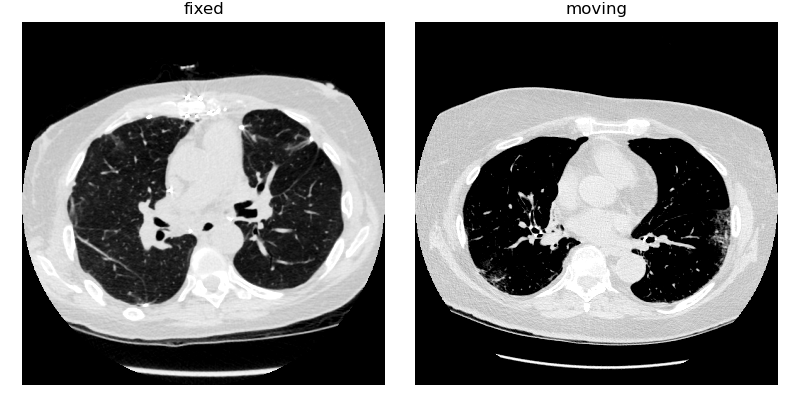

In [2]:
img1 = sitk.ReadImage('/Users/eva/Desktop/manifest-1648618045475/3DImage_1B_000340.mha', sitk.sitkFloat32)#Healthy Lung
img2 = sitk.ReadImage('/Users/eva/Desktop/manifest-1648618045475/3DImage_26970.mha', sitk.sitkFloat32)#Infected Lung

fixed_image = img1 #Healty Lung
moving_image = img2 #Infected Lung
gui.MultiImageDisplay(image_list = [fixed_image, moving_image],                   
                      title_list = ['fixed', 'moving'], figure_size=(8,4));

## Classic Registration

Estimate a 3D rigid transformation between images of different modalities. 

We have made the following choices with respect to initialization and registration component settings:

<ul>

<li>Similarity metric, mutual information (Mattes MI):
<ul>
  <li>Number of histogram bins, 50.</li>
  <li>Sampling strategy, random.</li>
  <li>Sampling percentage, 1%.</li>
</ul>
</li>
<li>Interpolator, sitkLinear.</li>
<li>Optimizer, gradient descent: 
<ul>
  <li>Learning rate, step size along traversal direction in parameter space, 1.0 .</li>
  <li>Number of iterations, maximal number of iterations, 100.</li>
  <li>Convergence minimum value, value used for convergence checking in conjunction with the energy profile of the similarity metric that is estimated in the given window size, 1e-6.</li>
  <li>Convergence window size, number of values of the similarity metric which are used to estimate the energy profile of the similarity metric, 10.</li>
</ul>
</li>
</ul>

We initialize registration by aligning the centers of the two volumes. To qualitatively evaluate the result we use a linked cursor approach, click on one image and the corresponding point is added to the other image.

<IPython.core.display.Javascript object>


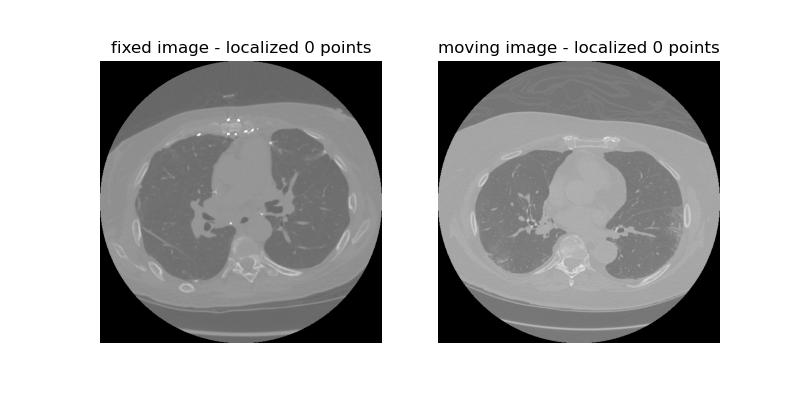

In [3]:
#initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
#                                                      moving_image, 
#                                                      sitk.AffineTransform(3), 
#                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)
#Affine does not perform well with our set of lungs. 


#initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
#                                                      moving_image, 
#                                                      sitk.Similarity3DTransform(), 
#                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

#sitk.VersorTransform([0,0,1,0]) - when selecting the intial points, it select a point in the diagonal plane, example quadrant 1 would show up in quadrant 3
#sitk.VersorTransform([0,0,1,0], [10,10,10]) - same as above
#sitk.Similarity3DTransform() - Better need to compare to Euler3DTransform()

initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

gui.RegistrationPointDataAquisition(fixed_image, moving_image, figure_size=(8,4), known_transformation=initial_transform);

In [4]:
registration_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
registration_method.SetMetricSamplingPercentage(1)


registration_method.SetInterpolator(sitk.sitkLinear)
#Euler - sitkLinear: 0.208
#Euler -sitkBSpline: 0.1906
#Euler - NearestNeighbor: 0.1924
#Euler - sitkGaussian - too computer intensive 

# Optimizer settings.
#registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100)
#registration_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.            
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [6,4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[3,2,1,0])
#registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times.
registration_method.SetInitialTransform(initial_transform, inPlace= False)

# Connect all of the observers so that we can perform plotting during registration.
#registration_method.AddCommand(sitk.sitkStartEvent, rgui.start_plot)
#registration_method.AddCommand(sitk.sitkEndEvent, rgui.end_plot)
#registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, rgui.update_multires_iterations) 
#registration_method.AddCommand(sitk.sitkIterationEvent, lambda: rgui.plot_values(registration_method))

final_transform = registration_method.Execute(fixed_image, moving_image)

# Always check the reason optimization terminated.
print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))

Final metric value: -0.20856665169970626
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 9.


Qualitatively evaluate the result using a linked cursor approach (visual evaluation):

<IPython.core.display.Javascript object>


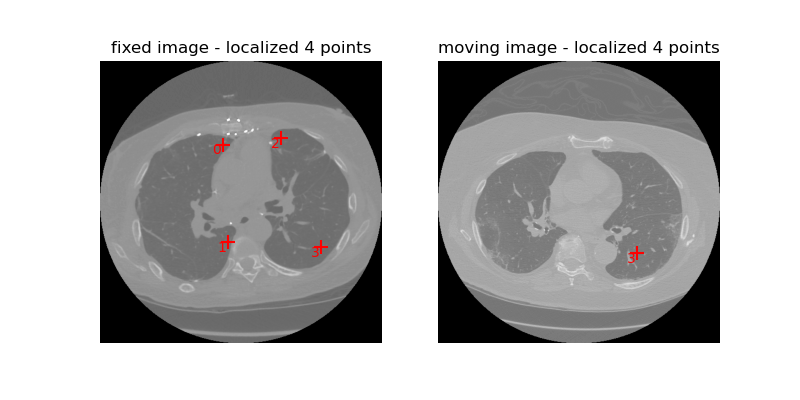

In [5]:
gui.RegistrationPointDataAquisition(fixed_image, moving_image, figure_size=(8,4), known_transformation=final_transform);

In [6]:
moving_resampled = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
sitk.WriteImage(moving_resampled, 'resampled_registered_lung_infected.mha')
#sitk.WriteTransform(final_transform, os.path.join(OUTPUT_DIR, 'RIRE_training_001_CT_2_mr_T1.tfm'))

In [7]:
myshow(moving_resampled)

interactive(children=(IntSlider(value=107, description='z', max=215), Output()), _dom_classes=('widget-interac…

## Segmentation

<IPython.core.display.Javascript object>


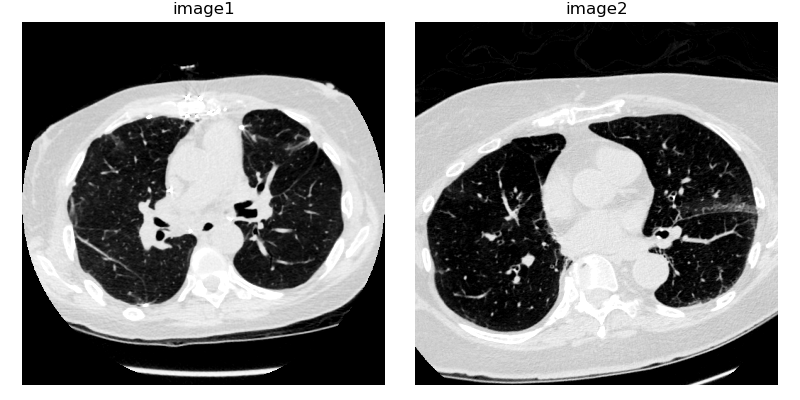

In [9]:
#Import image
#img11 = sitk.ReadImage('/Users/eva/Desktop/manifest-1648618045475/3DImage_1B_000340.mha')
#img22 = sitk.ReadImage('/Users/eva/Desktop/manifest-1648618045475/3DImage_26970.mha')

img11 = img1 #Healthy Lung
img22 = moving_resampled #Infected Lung

#img1 = sitk.InvertIntensity(img1)
#img2 = sitk.InvertIntensity(img2)

#Display Initial Image
gui.MultiImageDisplay(image_list = [img11, img22],                   
                      title_list = ['image1', 'image2'],
                      figure_size=(8,4));

<IPython.core.display.Javascript object>


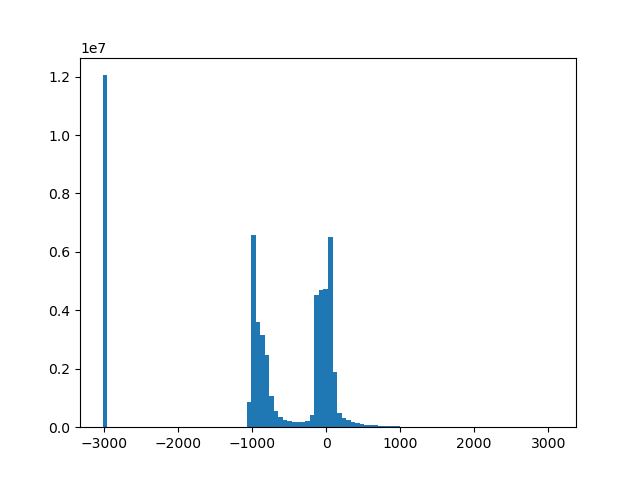

<IPython.core.display.Javascript object>


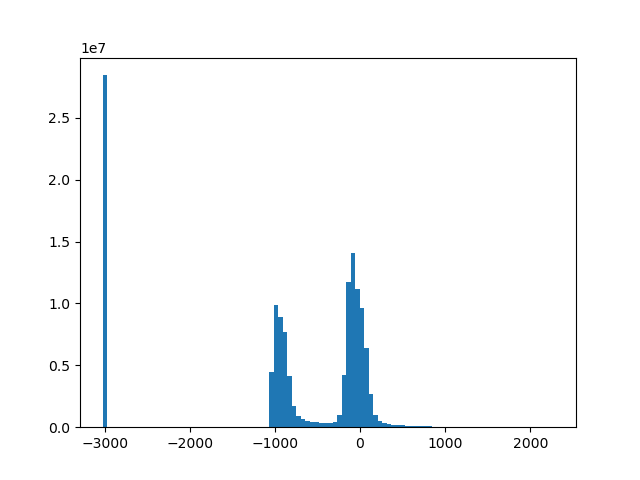

In [12]:
#Display histogram for image 1
plt.figure()
plt.hist(sitk.GetArrayViewFromImage(img1).flatten(), bins=100)
plt.show()

#Display histogram for image 2
plt.figure()
plt.hist(sitk.GetArrayViewFromImage(img2).flatten(), bins=100)
plt.show()

In [ ]:
#img1_4065 = sitk.Cast(sitk.IntensityWindowing(img1, windowMinimum=0, windowMaximum=1200, 
#                                             outputMinimum=0.0, outputMaximum=4095.0), sitk.sitkInt32)
#img2_4065 = sitk.Cast(sitk.IntensityWindowing(img2, windowMinimum=0, windowMaximum=1200, 
#                                             outputMinimum=0.0, outputMaximum=4095.0), sitk.sitkInt32)
    
#Display windowed Image
#gui.MultiImageDisplay(image_list = [img1_4065, img2_4065],                   
#                      title_list = ['image1', 'image2'],
#                      figure_size=(8,4));

In [ ]:
#Display histogram for image 1
#plt.figure()
#plt.hist(sitk.GetArrayViewFromImage(img1_4065).flatten(), bins=100)
#plt.show()

#Display histogram for image 2
#plt.figure()
#plt.hist(sitk.GetArrayViewFromImage(img2_4065).flatten(), bins=100)
#plt.show()

In [17]:
seg_img1 = sitk.BinaryThreshold(img11, lowerThreshold=-1500, upperThreshold=-370, insideValue=0, outsideValue=1)
myshow(seg_img1)
seg_img2 = sitk.BinaryThreshold(img22, lowerThreshold=-1500, upperThreshold=-370, insideValue=0, outsideValue=1)
myshow(seg_img2)

interactive(children=(IntSlider(value=107, description='z', max=215), Output()), _dom_classes=('widget-interac…

interactive(children=(IntSlider(value=107, description='z', max=215), Output()), _dom_classes=('widget-interac…

In [19]:
seed1 = (170, 200, 107)
seg1 = sitk.ConfidenceConnected(
    seg_img1,
    seedList=[seed1],
    numberOfIterations=1,
    multiplier=2.5,
    initialNeighborhoodRadius=1,
    replaceValue=1,
)

seed2 = (170, 280, 127)
seg2 = sitk.ConfidenceConnected(
    seg_img2,
    seedList=[seed2],
    numberOfIterations=1,
    multiplier=2.5,
    initialNeighborhoodRadius=1,
    replaceValue=1,
)

#myshow(sitk.LabelOverlay(seg_img1, seg1), "ConfidenceConnected")
#result_img1 = sitk.LabelOverlay(seg_img1, seg1)

#myshow(sitk.LabelOverlay(seg_img2, seg2), "ConfidenceConnected")
#result_img2 = sitk.LabelOverlay(seg_img2, seg2)

myshow(seg1)
myshow(seg2)

interactive(children=(IntSlider(value=107, description='z', max=215), Output()), _dom_classes=('widget-interac…

interactive(children=(IntSlider(value=107, description='z', max=215), Output()), _dom_classes=('widget-interac…

<IPython.core.display.Javascript object>


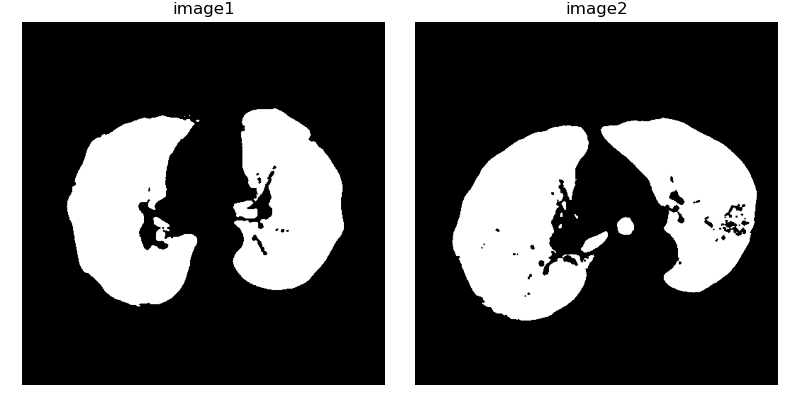

In [30]:
vectorRadius = (1, 1, 1)
kernel = sitk.sitkBall
#seg_implicit_thresholds_clean = sitk.BinaryMorphologicalOpening(
#    result, vectorRadius, kernel
#)
seg_implicit_thresholds_clean_1 = sitk.BinaryMorphologicalClosing(
    seg1, vectorRadius, kernel
)
seg_implicit_thresholds_clean_2 = sitk.BinaryMorphologicalClosing(
    seg2, vectorRadius, kernel
)
gui.MultiImageDisplay(image_list = [seg_implicit_thresholds_clean_1, seg_implicit_thresholds_clean_2],                   
                      title_list = ['image1', 'image2'],
                      figure_size=(8,4));

In [ ]:
#sitk.WriteImage(seg_implicit_thresholds_clean_1, '1B_000034_Seg_Result.mha') 

### Overlay segmentation result with original image

In [28]:
overlay_1 = sitk.Cast(seg_implicit_thresholds_clean_1, sitk.sitkFloat32) * sitk.InvertIntensity(img11)
overlay_2 = sitk.Cast(seg_implicit_thresholds_clean_2, sitk.sitkFloat32) * sitk.InvertIntensity(img22)

<IPython.core.display.Javascript object>


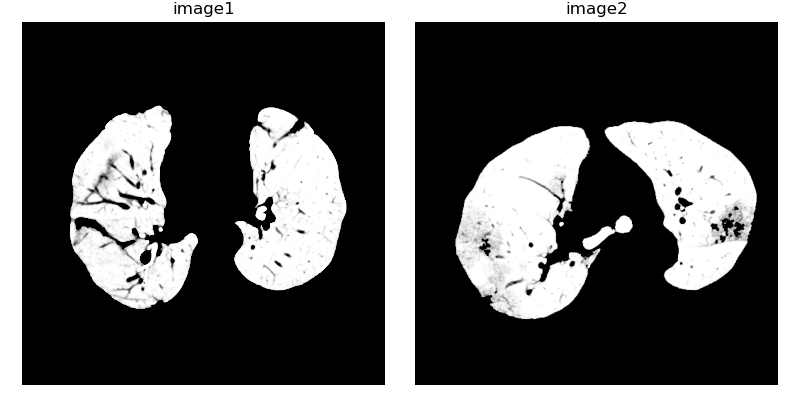

In [29]:
gui.MultiImageDisplay(image_list = [overlay_1, overlay_2],                   
                      title_list = ['image1', 'image2'],
                      figure_size=(8,4));

## Histogram Equalization

<IPython.core.display.Javascript object>


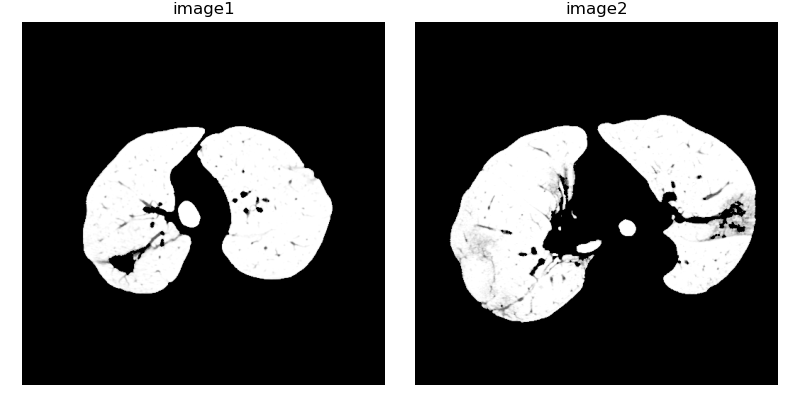

In [37]:
img1_4095 = sitk.Cast(sitk.IntensityWindowing(overlay_1, windowMinimum=0, windowMaximum=1058, 
                                             outputMinimum=0.0, outputMaximum=4095.0), sitk.sitkInt32)
img2_4095 = sitk.Cast(sitk.IntensityWindowing(overlay_2, windowMinimum=0, windowMaximum=1058, 
                                             outputMinimum=0.0, outputMaximum=4095.0), sitk.sitkInt32)
    
#Display windowed Image
gui.MultiImageDisplay(image_list = [img1_4095, img2_4095],                   
                      title_list = ['image1', 'image2'],
                      figure_size=(8,4));

<IPython.core.display.Javascript object>


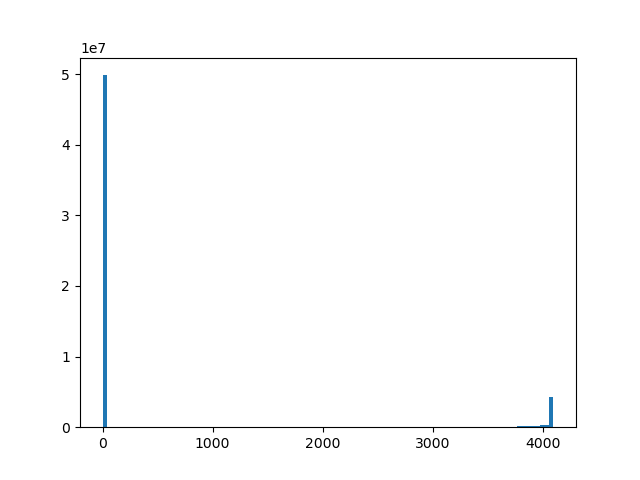

<IPython.core.display.Javascript object>


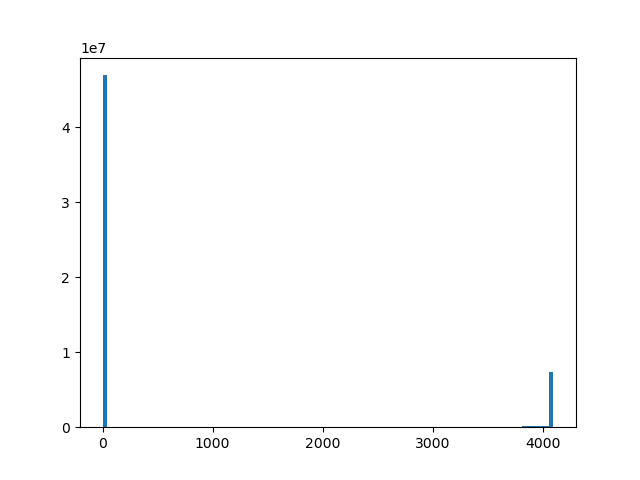

In [38]:
#Display histogram for image 1
plt.figure()
plt.hist(sitk.GetArrayViewFromImage(img1_4095).flatten(), bins=100)
plt.show()

#Display histogram for image 2
plt.figure()
plt.hist(sitk.GetArrayViewFromImage(img2_4095).flatten(), bins=100)
plt.show()

<IPython.core.display.Javascript object>


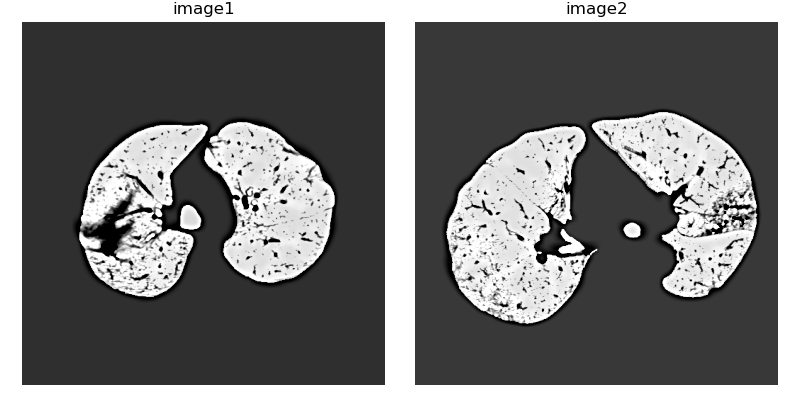

In [41]:
test1 = sitk.AdaptiveHistogramEqualization(img1_4095)
test2 = sitk.AdaptiveHistogramEqualization(img2_4095)
#Display windowed Image
gui.MultiImageDisplay(image_list = [test1, test2],                   
                      title_list = ['image1', 'image2'],
                      figure_size=(8,4));

<IPython.core.display.Javascript object>


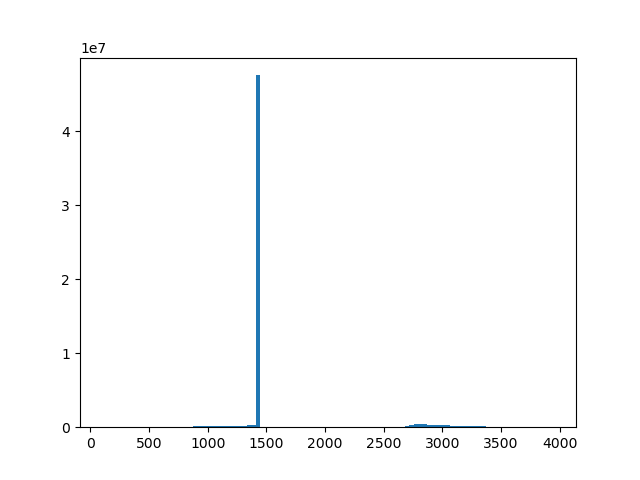

<IPython.core.display.Javascript object>


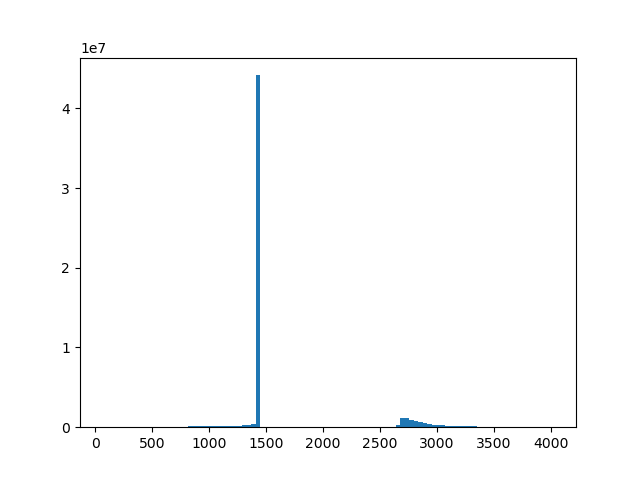

In [42]:
#Display histogram for image 1
plt.figure()
plt.hist(sitk.GetArrayViewFromImage(test1).flatten(), bins=100)
plt.show()

#Display histogram for image 2
plt.figure()
plt.hist(sitk.GetArrayViewFromImage(test2).flatten(), bins=100)
plt.show()